# **CLIP Explainability**

In [4]:
!git clone https://github.com/hila-chefer/Transformer-MM-Explainability # check this out!

import os
os.chdir(f'./Transformer-MM-Explainability')

!pip install -q einops ftfy captum

fatal: destination path 'Transformer-MM-Explainability' already exists and is not an empty directory.


# **CLIP**

In [5]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [6]:
# Control context expansion (number of attention layers to consider)

# Number of layers for image Transformer
start_layer =  -1

# Number of layers for text Transformer
start_layer_text =  -1

In [26]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()

    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]


    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]

    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def show_image_relevance(image_relevance, image, orig_image):
    # Helper function: overlay heatmap on the image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255  # Normalize heatmap
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)  # Normalize the combined image
        return cam

    # Plot original image and heatmap side by side
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image)
    axs[0].axis('off')  # Turn off axis for the original image

    # Convert image relevance to a 2D mask
    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)

    # Resize the relevance map to the size of the image (224x224)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()

    # Normalize the relevance map
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())

    # Process the original image for visualization
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    # Overlay relevance heatmap on the image
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)

    # Convert the image from RGB to BGR for display
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    # Show the heatmap on the image
    axs[1].imshow(vis)
    axs[1].axis('off')  # Turn off axis for the heatmap image

    # Remove legend (no need to add any legend function)
    plt.tight_layout()
    plt.show()


In [21]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
    # Get the index of the [CLS] token (argmax over the text encoding)
    # CLS_idx: Scalar representing the index of the CLS token
    CLS_idx = text_encoding.argmax(dim=-1)

    # Extract relevance scores for the tokens between [CLS] and the [SEP] or end
    # R_text: (CLS_idx - 1,) - Relevance for tokens (excluding [CLS])
    R_text = R_text[CLS_idx, 1:CLS_idx]

    # Normalize the relevance scores
    text_scores = R_text / R_text.sum()  # (CLS_idx - 1,)
    text_scores = text_scores.flatten()  # Flatten into 1D array

    # Print text scores (for debugging purposes)
    print(text_scores)

    # Tokenize the input text
    text_tokens = _tokenizer.encode(text)  # List of token IDs

    # Decode the tokens back to words (or subwords)
    # text_tokens_decoded: List of token strings
    text_tokens_decoded = [_tokenizer.decode([a]) for a in text_tokens]

    # Prepare the data for visualization
    vis_data_records = [visualization.VisualizationDataRecord(text_scores, 0, 0, 0, 0, 0, text_tokens_decoded, 1)]

    # Visualize the text with relevance heatmap
    visualization.visualize_text(vis_data_records)


In [22]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [24]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

tokenized text: tensor([[49406,   320,   786,   593,  5034,  6116, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='cuda:0')
tensor([0.0276, 0.0643, 0.0049, 0.1692, 0.7344], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with eye glasses


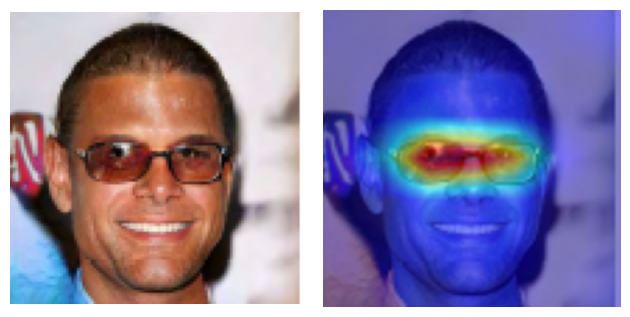

In [46]:
img_path = "CLIP/glasses.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

texts = ["a man with eyeglasses"]
text = clip.tokenize(texts).to(device)
print("tokenized text:", text)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]

for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0203, 0.9800], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a zebra


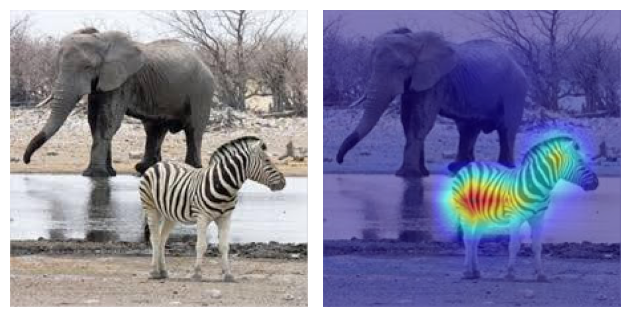

tensor([0.0352, 0.9648], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an elephant


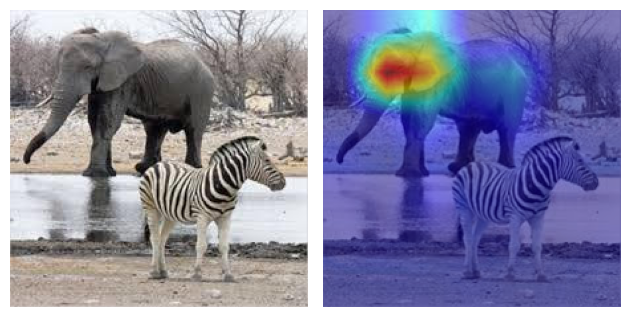

tensor([0.5479, 0.4526], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a lake


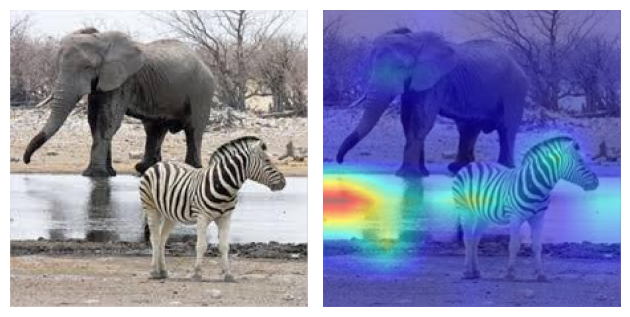

In [39]:
img_path = "CLIP/el2.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

texts = ['a zebra', 'an elephant', 'a lake']
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]

for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0237, 0.9766], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a labrador


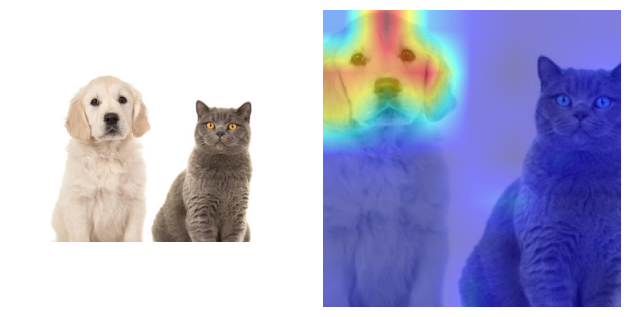

tensor([0.0448, 0.5820, 0.3733], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a tabby cat


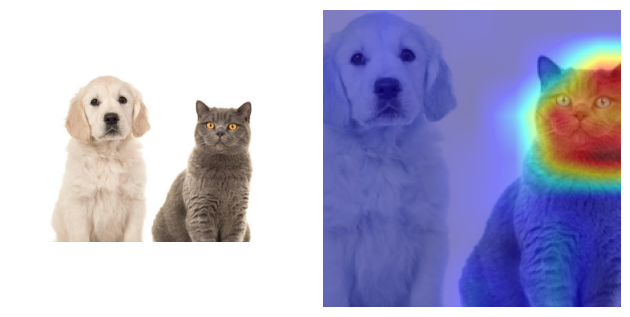

In [31]:
img_path = "CLIP/dogcat2.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

texts = ["a labrador", "a tabby cat"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]

for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0726, 0.1309, 0.0593, 0.0403, 0.6973], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a portrait of an astronaut


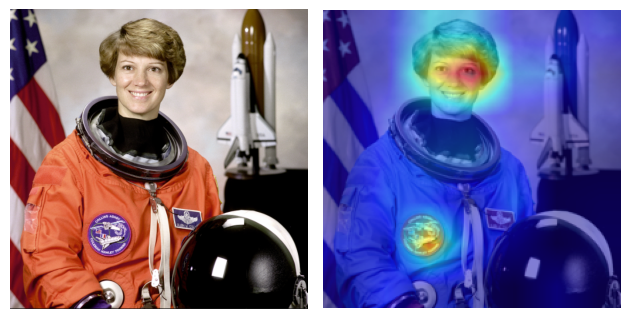

tensor([0.5303, 0.4692], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a rocket


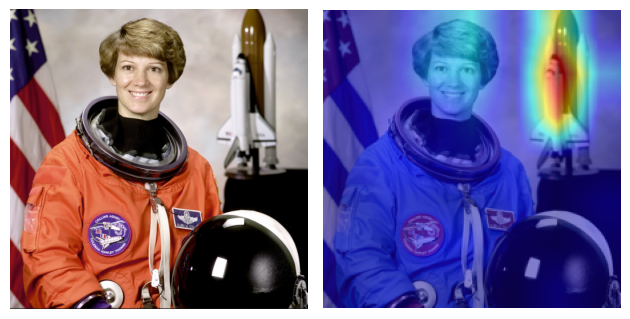

tensor([0.2219, 0.6348, 0.1434], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an astronaut suit


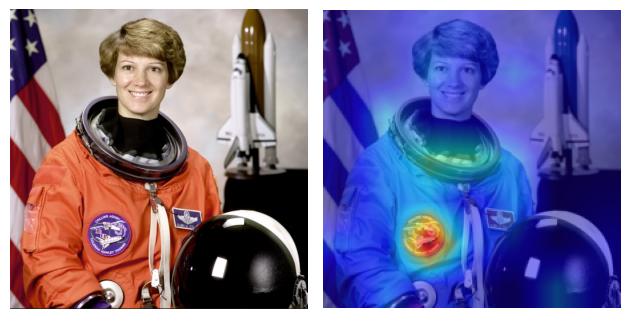

In [45]:
img_path = "CLIP/astronaut.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

texts = ["a portrait of an astronaut", "a rocket", "an astronaut suit"]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]

for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

# Examples of biased similarity scores (noise scores higher than dog)

CLIP similarity score: 26.96875
tensor([0.0316, 0.3076, 0.0707, 0.0164, 0.5737], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an image of a dog


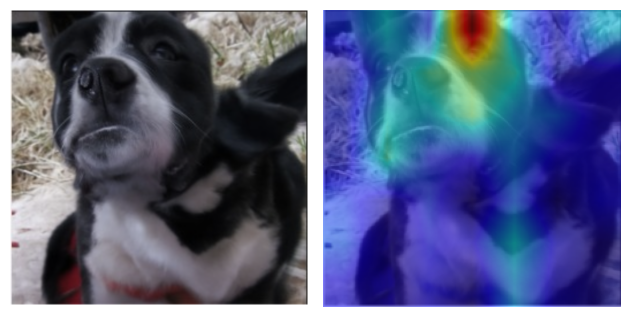

In [33]:
img_path = "CLIP/dog.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

texts = ["an image of a dog"]
text = clip.tokenize(texts).to(device)

logits_per_image, logits_per_text = model(img, text)
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {logits_per_image.item()}' + color.END)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]

for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

CLIP similarity score: 28.71875
tensor([0.0594, 0.3025, 0.4736, 0.0611, 0.1034], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,an image of a dog


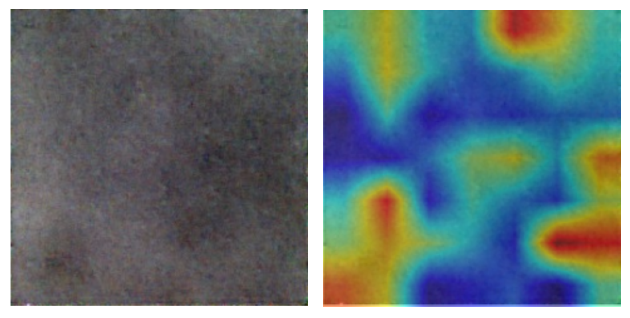

In [34]:
img_path = "CLIP/noise.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["an image of a dog"]
text = clip.tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {logits_per_image.item()}' + color.END)
R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()